# Week 5 Final Peer-Graded Assignment

Student, University of Colorado Boulder

For the week 5 final peer-graded assignment, I want to use Unsupervised Machine Learning methods to identify ETFs that can be pairs-traded.

#### Terminology

* ETF: An Exchange-Traded Fund (ETF) is a collection of securities that can be bought and sold on a stock exchange similar to a company's stock. ETFs are SEC-registered and they allow investors to pool their money into a fund that invests in a variety of assets.
* Pairs-Trading: Pairs trading is a non-directional investment strategy that involves buying and selling two or more securities or derivatives.  It involves matching a long position with a short position in two different securities or derivatives with a high correlation.
* Long position: The term long position describes what an investor has purchased when they buy a security or derivative with the expectation that it will rise in value.
* Short position: A short, or a short position, is created when a trader sells a security or derivative first with the intention of repurchasing it or covering it later at a lower price. A trader may decide to short a security or derivative when the trader believes that the price of that security is likely to decrease in the near future.
* Non-directional trading strategy: In non-directional trading strategies, buying and selling takes place in different contracts of the same security or derivative  or two interrelated security or derivative of the same contract or different contracts simultaneously where the loss in one contract is offset by gain in the other contract.

The intent behind finding ETFs that can be pairs-traded is to profit from the relative price movements of the two securities.  The idea is to find patterns in ETFs that make them converge ultimately after a divergence and use this knowledge to pairs-trade while hedging against each security contract.

I will use Unsupervised Machine Learning techniques to identify ETFs that can be pair-traded.  There are ~290 ETFs in the US/NASDAQ market and it is time consuming to manually find pairs of ETFs that are highly correlated.  I will be using K-Means clustering to bucket the ETFs into clusters and find pairs in each cluster to find pairs.  Later I will use DBSCAN to do the same.


In [62]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN

from sklearn import metrics
from sklearn.decomposition import PCA
from kneed import KneeLocator

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yfinance as yf

### Data Extraction

I will be looking at the 5 year period starting 2018 and ending 2022 for this exercise.  The data can be reused once downloaded and so I will be using some variables to either fetch the data or load the fetched data.

In [10]:
start_dt = "2018-1-1"
end_dt = "2022-12-31"

file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"

load_existing = True
load_coint_pairs = False

I will be using yfinance - which uses Yahoo! finance APIs, to fetch the required information.

I will be using only the Adjusted Close values of ETFs to cluster them.  The strategy uses only price movements to infer the correlation so Asjusted Close makes sense to be used

In [11]:
if not load_existing:
    yf.pdr_override()
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) &(symbols["Market Category"] == "G")]
    symbols = list(symbols.index.values)
    data = pdr.data.get_data_yahoo(symbols,  start=start_dt, end=end_dt)['Adj Close']  
    data.to_csv(file_name)
else:
    data = pd.read_csv(file_name)

### Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the data


Let us drop any values that are NA since they will affect our calculations

In [13]:
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print(f'shape {data.shape}')
print(f'null values: {data.isnull().values.any()}')

shape (1259, 290)
null values: False


In [14]:
data.head()

,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,56.432438,69.671516,64.822205,42.984760,18.754854,18.930815,59.581520,27.197104,9.422737,21.941908,...,40.077320,130.861176,57.009167,98.178925,60.017406,47.918690,52.241989,64.786133,33.830147,25.058256
2018-01-03,57.022038,70.279839,65.151787,43.257137,19.033163,18.868071,60.208321,27.206991,9.478272,22.007908,...,40.085541,131.801468,57.064587,98.196793,60.077084,48.252728,52.485199,65.046417,34.103355,25.157690
2018-01-04,57.237278,70.396149,65.606087,43.580593,18.917439,18.915129,60.437862,27.365166,9.484447,22.147247,...,40.093761,132.156555,57.226204,98.420006,60.084572,48.653591,53.021820,64.974609,34.235252,25.157690
2018-01-05,57.686501,71.040260,66.033661,43.895515,19.079067,18.919043,60.843956,27.177330,9.496172,22.154575,...,40.085541,132.501953,57.401691,98.580711,60.166660,48.979275,53.276627,65.351593,34.517879,25.157690
2018-01-08,57.686501,71.111824,66.096024,43.895515,19.022640,18.958265,60.861614,27.246531,9.509130,22.183912,...,40.077320,132.434814,57.461727,98.946800,60.024853,48.954227,53.160816,65.683678,34.555557,25.157690


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2018-01-02 to 2022-12-30
Columns: 290 entries, AADR to YLDE
dtypes: float64(290)
memory usage: 2.8+ MB


Each row corresponds to the Adjusted Close price of different securities on that particular date.  The dates range from 1-JAN-2018 to 31-DEC-2022 and on dates when the markets are not open, we will not have entries.  

Each column corresponds to the Adjusted Close price of one security over different dates.  AADR is an ETF and so are AAXJ, ACWI, ACWX etc. Data types are date and float

### Feature Engineering

The price movement is captured in two ways - one is returns and the other is volatility

A return is the change in price of an asset, investment, or project over time, which may be represented in terms of price change or percentage change. Here we are using the percentage change

Volatility is how much and how quickly prices move over a given span of time. In the stock market, increased volatility is often a sign of fear and uncertainty among investors.

In [66]:
# create dataframe with returns and volatility information
df_returns = pd.DataFrame(data.pct_change().mean()*255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std()*np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,-0.005038,0.245159
AAXJ,0.006999,0.229101
ACWI,0.071918,0.205415
ACWX,0.025977,0.202069
AGNG,0.085991,0.200920


<Axes: ylabel='Frequency'>

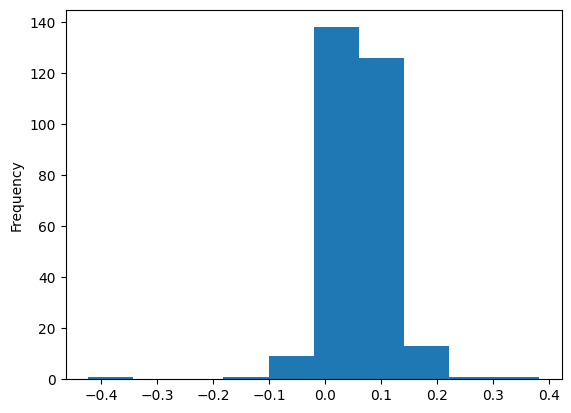

In [65]:
df_returns.Returns.plot.hist()

<Axes: ylabel='Frequency'>

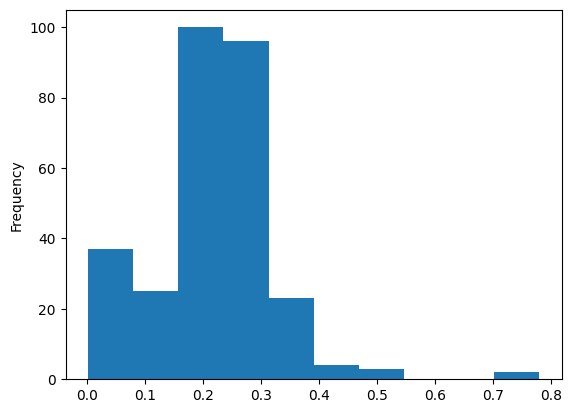

In [67]:
df_returns.Volatility.plot.hist()

I will standardize the data before clustering

In [16]:
# scale features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,-1.004415,0.244185
AAXJ,-0.814386,0.090517
ACWI,0.210470,-0.136140
ACWX,-0.514787,-0.168164
AGNG,0.432645,-0.179162


<Axes: ylabel='Frequency'>

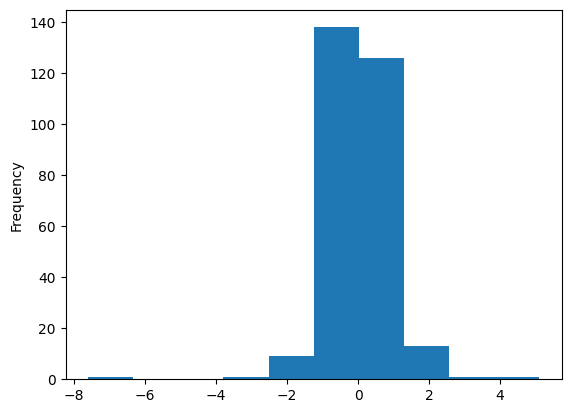

In [70]:
df_scaled.Returns.plot.hist()

<Axes: ylabel='Frequency'>

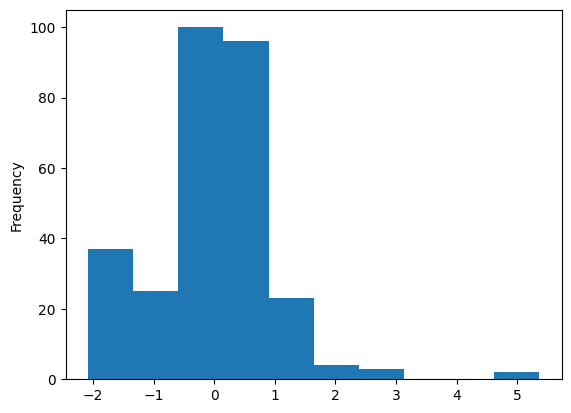

In [71]:
df_scaled.Volatility.plot.hist()

### K-Means Clustering

I will use KneeLocator to find optimum number of clusters for the K-Means Clustering

In [17]:
# Find optimum number of clusters
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print(f'optimum clusters {c}')

optimum clusters 5


In [18]:
# Fit K-Means model with the optimum clusters
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

I will plot the clusters and mark the centroids to see if there are any outliers

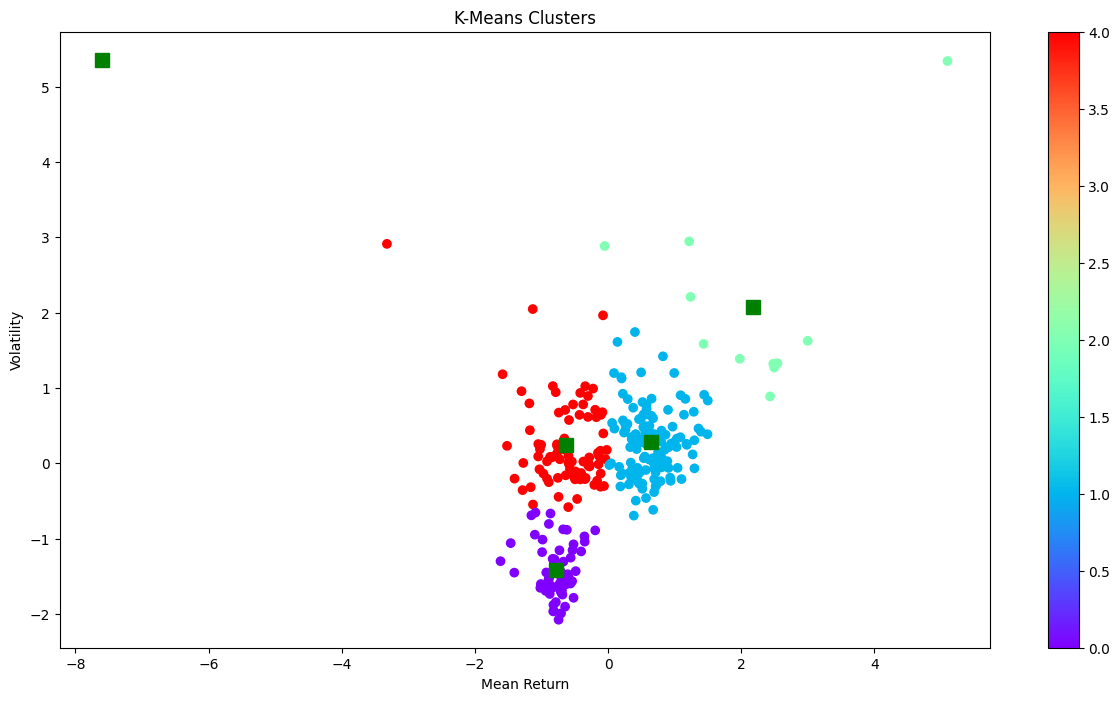

In [73]:
centroids = k_means.cluster_centers_
fig =plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap='rainbow', label=X.index)
ax.set_title('K-Means Clusters')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=10)
plt.show()

In [23]:
cs = pd.Series(index=X.index, data=k_means.labels_.flatten())
cs_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
cs = cs [cs != -1]
cs[:15]

AADR    4
AAXJ    4
ACWI    1
ACWX    4
AGNG    1
AGZD    0
AIA     4
AIRR    1
ALTY    4
ANGL    0
ASET    4
BBH     1
BIB     2
BIS     4
BJK     4
dtype: int32

There seems to be outliers.  I can either adjust the clusters or get rid of the outliers but I will ignore that for now

I will plot the number of ETFs per cluster

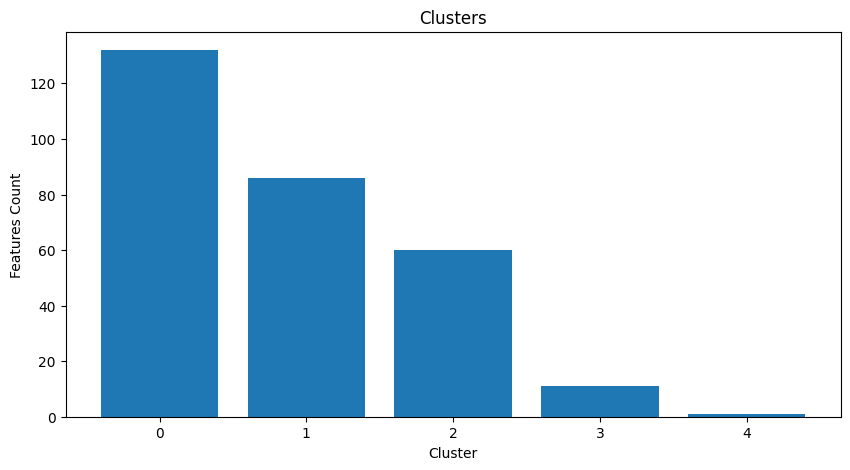

In [24]:

plt.figure(figsize=(10,5))
plt.bar(range(len(cs.value_counts())), cs.value_counts())
plt.title('Clusters')
plt.xlabel('Cluster')
plt.ylabel('Features Count')
plt.show()

I will find the cointegration between each of the ETFs with other ETFs in the same cluster.  Since the matrix is going to be huge, I will limit the number of combinations by not running the same over all ETFs in all clusters

In [25]:
# Remove items
clusters_clean = cs[cs < 4]
print(f'feature number previous {len(cs)}, current {len(clusters_clean)}')

feature number previous 290, current 204


This is still a significant number and the cointegration can take an hour to complete
Cointegration is a tool for modeling long-term relationships in time series data.  I will be using a p value of < 0.05 and this should be adjusted according to the risk profile of investors

In [28]:
def calculate_cointegration(series1, series2):
    coint_flag = 0
    coint_res = coint(series1, series2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    crit_val = coint_res[2][1]
    model = sm.OLS(series1, series2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < crit_val else 0
    return coint_flag, hedge_ratio

In [29]:
# find cointegrated pairs
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]
        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]

            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                series1 = data[base_asset].values.astype(float)
                series2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series1, series2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset":base_asset, "compare_asset":compare_asset, "label":base_label})
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by='label')
    df_coint.to_csv(file_name_coint)

In [30]:
df_coint = pd.read_csv(file_name_coint)
df_coint.head()

,Unnamed: 0,base_asset,compare_asset,label
0,150,FTSL,VTIP,0
1,117,FIXD,IUSB,0
2,113,FCAL,HYXF,0
3,112,FCAL,HYLS,0
4,103,EMCB,VGSH,0


Now that I have computed the cointegration, I will visualize price movement to see if the clustering has indeed identified correctly

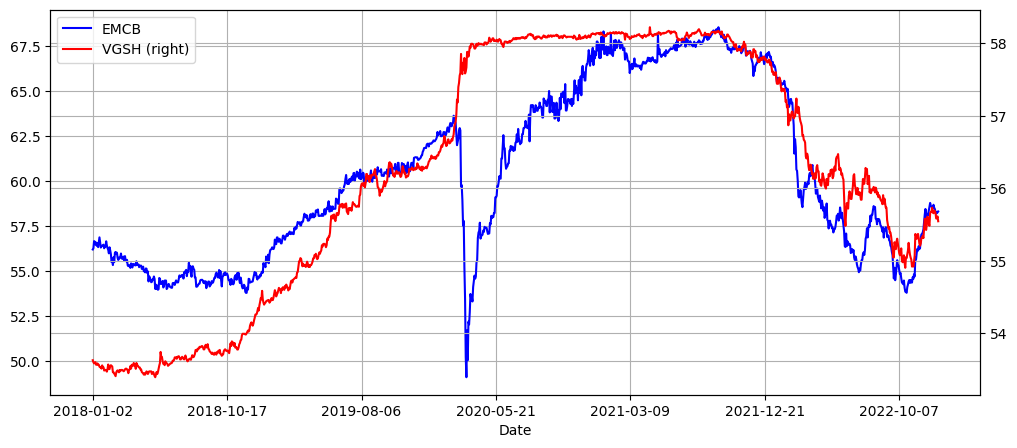

In [33]:
def plot_series(etf1, etf2):
    plt.figure(figsize=(12,5))    
    ax1 = data[etf1].plot(color='blue', grid=True, label=etf1)
    ax2 = data[etf2].plot(color='red', grid=True, secondary_y=True, label=etf2)
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    
    
    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()

plot_series('EMCB', 'VGSH')

I can see that the price movement does show some level of cointegration.  A trader can pair-trade these two ETFs by initiating the trade when the two securities diverge and close the trade when they no longer diverge.

A trader can also use other methods like T-SNE to filter out the pairs

### DBSCAN

I will now use DBSCAN, which is another Unsupervised Machine Learning technique, to find clusters.  Since there is no test results to compare and find which method provides best clusters, I will not be doing any comparision between these two methods.

Calculate the percentage change of each of the securities and drop the first column because percentage change of first columns will be NA

In [74]:
df_ret = data.pct_change().T

In [47]:
df_ret.head()

Date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,...,2022-12-16,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-27,2022-12-28,2022-12-29,2022-12-30
AADR,NaN,0.010448,0.003775,0.007848,0.000000,0.004705,-0.003391,0.007291,0.006434,-0.010708,...,-0.000210,-0.002312,0.014114,0.013710,-0.007172,0.006053,-0.011618,-0.005038,0.007595,0.000000
AAXJ,NaN,0.008731,0.001655,0.009150,0.001007,-0.001006,-0.006171,0.006082,0.009446,-0.004616,...,0.000925,-0.000462,-0.004776,0.009288,-0.008896,-0.001702,0.019377,-0.020377,0.020180,-0.014151
ACWI,NaN,0.005084,0.006973,0.006517,0.000944,0.001213,-0.002288,0.006881,0.007638,-0.001729,...,-0.009679,-0.006123,0.002251,0.013122,-0.012019,0.004606,-0.000353,-0.012937,0.017395,-0.005973
ACWX,NaN,0.006337,0.007478,0.007226,0.000000,-0.000194,-0.002715,0.006029,0.009086,-0.002108,...,-0.005918,-0.001764,0.002872,0.010573,-0.009154,0.002860,0.006361,-0.012206,0.015225,-0.011085
AGNG,NaN,0.014839,-0.006080,0.008544,-0.002958,0.013072,-0.006948,0.003198,0.007771,0.003460,...,-0.005319,-0.011268,0.003284,0.010589,-0.000724,-0.001754,-0.004889,-0.006602,0.017480,-0.004447


In [48]:
df_ret = df_ret.drop(['2018-01-02'], axis = 1)
df_ret.head()

Date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-12-16,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-27,2022-12-28,2022-12-29,2022-12-30
AADR,0.010448,0.003775,0.007848,0.000000,0.004705,-0.003391,0.007291,0.006434,-0.010708,0.012601,...,-0.000210,-0.002312,0.014114,0.013710,-0.007172,0.006053,-0.011618,-0.005038,0.007595,0.000000
AAXJ,0.008731,0.001655,0.009150,0.001007,-0.001006,-0.006171,0.006082,0.009446,-0.004616,0.012033,...,0.000925,-0.000462,-0.004776,0.009288,-0.008896,-0.001702,0.019377,-0.020377,0.020180,-0.014151
ACWI,0.005084,0.006973,0.006517,0.000944,0.001213,-0.002288,0.006881,0.007638,-0.001729,0.007859,...,-0.009679,-0.006123,0.002251,0.013122,-0.012019,0.004606,-0.000353,-0.012937,0.017395,-0.005973
ACWX,0.006337,0.007478,0.007226,0.000000,-0.000194,-0.002715,0.006029,0.009086,-0.002108,0.007295,...,-0.005918,-0.001764,0.002872,0.010573,-0.009154,0.002860,0.006361,-0.012206,0.015225,-0.011085
AGNG,0.014839,-0.006080,0.008544,-0.002958,0.013072,-0.006948,0.003198,0.007771,0.003460,0.001478,...,-0.005319,-0.011268,0.003284,0.010589,-0.000724,-0.001754,-0.004889,-0.006602,0.017480,-0.004447


In [49]:
df_ret = df_ret.dropna()
df_ret.shape

(290, 1258)

There are no NAs in the data

Since there are 290 ETFs, and 1258 entries for each ETF, I will employ PCA to reduce the dimensions 

In [50]:
N_COMPONENTS = 50
pca1 = PCA(n_components=N_COMPONENTS)
pca1.fit(df_ret.T)
pca1.components_.T.shape
rp = pd.DataFrame(data = pca1.components_.T, index = df_ret.index)
rp = rp.add_prefix("P")
rp.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49
AADR,-0.061433,-0.019248,0.081574,-0.009151,-0.048022,-0.051882,0.005757,0.020720,-0.095846,-0.007642,...,-0.006511,-0.073679,0.045243,0.047299,0.035449,0.021931,0.071499,0.035319,-0.035626,0.024307
AAXJ,-0.056254,-0.035239,0.128929,-0.034433,0.033827,0.095175,0.022418,-0.010603,0.063846,0.047697,...,-0.032114,-0.002352,-0.024920,-0.003473,-0.036600,0.023372,-0.023277,-0.035487,0.003228,-0.003795
ACWI,-0.060442,-0.010400,0.012273,0.035721,0.020457,-0.006052,0.040562,0.002567,0.016992,0.005628,...,-0.002354,0.011312,-0.007169,-0.004106,0.003505,0.003093,0.010894,0.000805,-0.015082,0.009248
ACWX,-0.057109,0.004143,0.071720,0.021649,0.001673,0.022306,0.041728,0.025414,-0.012677,-0.006864,...,-0.012153,0.017995,-0.016645,-0.013917,-0.011904,0.010010,0.009421,0.007744,-0.018898,0.006438
AGNG,-0.049541,-0.021704,-0.013275,0.018559,-0.091609,0.016464,0.038376,0.035400,0.025659,-0.024218,...,0.008644,-0.004148,0.121027,-0.050120,0.011265,0.003131,0.101109,-0.012133,-0.044917,-0.010627


In [52]:
# Use scaler to fit transform the data
scaled_data = StandardScaler().fit_transform(rp)
print(scaled_data.shape)

(290, 50)


In [53]:
print(scaled_data)

[[-0.38626675 -0.48610771  1.25417665 ...  0.57598041 -0.5806901
   0.39697003]
 [-0.2274297  -0.76165268  2.06970508 ... -0.63019803  0.08118657
  -0.08166634]
 [-0.35587748 -0.33365401  0.06069871 ... -0.0119636  -0.23072535
   0.14048615]
 ...
 [-0.58595574  0.62056194  0.33098073 ...  4.25638427  2.00452832
  -0.09002337]
 [-0.52773678 -0.90540737 -0.10979774 ...  0.23762814 -0.36239687
   0.4838707 ]
 [ 0.14876302  0.33515753 -0.41416744 ... -0.75690175  0.99902271
  -0.45001561]]


Now that I have the scaled data, I will run DBSCAN on this data to identify clusters

In [54]:
dbs = DBSCAN(eps=1.8, min_samples = 3, n_jobs = 1)
print(dbs)
dbs.fit(scaled_data)
labels = dbs.labels_
n_clus = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Clusters discovered: {n_clus}')

DBSCAN(eps=1.8, min_samples=3, n_jobs=1)
Clusters discovered: 8


In [55]:
cs = pd.Series(index = rp.index, data = labels.flatten())
cs_all = pd.Series(index = rp.index, data = labels.flatten())
cs = cs[cs != 1]

c_limit = 100
counts = cs.value_counts()
tcr = counts[(counts > 1) & (counts <= c_limit)]
print(f'Clusters formed:  len(tcr)')
print(f'Pairs to evaluate: (tcr*(tcr-1)).sum()')

Clusters formed: 7
Pairs to evaluate: 1214


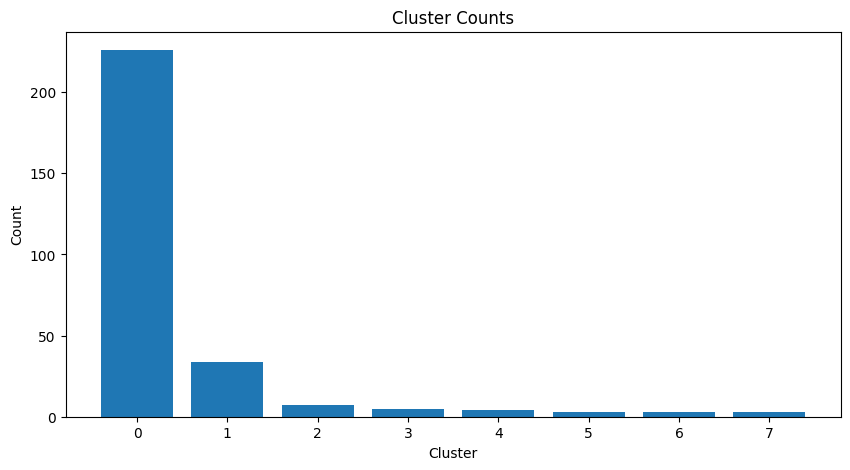

In [77]:
plt.figure(figsize = (10, 5))
plt.bar(range(len(cs.value_counts())), cs.value_counts())
plt.title('Cluster Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

I will pick a cluster and see if it contains any pairs that can be pairs-traded

In [58]:
etfs = list(cs[cs==2].index)
print(etfs)

['AGZD', 'BND', 'BNDX', 'BSCO', 'BSCP', 'BSCQ', 'BSCR', 'FIXD', 'FTSM', 'GNMA', 'IEF', 'IEI', 'IGIB', 'IGSB', 'ISTB', 'IUSB', 'LMBS', 'MBB', 'SHV', 'SHY', 'SKOR', 'SLQD', 'SUSB', 'SUSC', 'UITB', 'USIG', 'USTB', 'VCIT', 'VCSH', 'VGIT', 'VGSH', 'VMBS', 'VTC', 'VTIP']


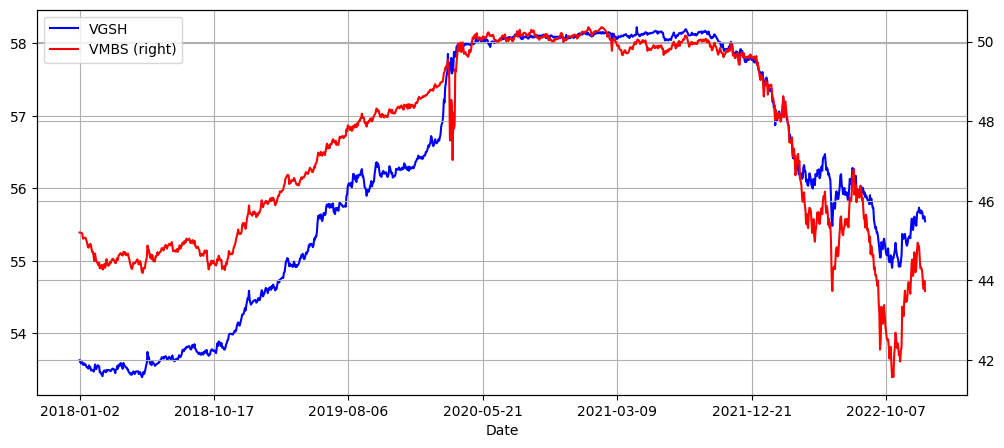

In [61]:
plot_series('VGSH', 'VMBS')

The price movement of the two ETFs show that they can be pairs-traded.

#### Future Tasks

Lot of tasks can be done in future.  Some of them are listed below:
* Use T-SNE to find better pairs
* Back test to find possible returns
* Extend this strategy to crypto or stocks
* Programmatically find best time to enter and exit the pairs-trading
* Use BIRCH or Agglomerative clustering to find clusters

#### Conclusion

I have used K-Means and DBSCAN to identify ETFs that can be pair traded.  There is more to be done before this can be used for actual trading, including employing T-SNE.  Also we can use the backtesting methods to find the possible profits if we employ this strategy.

Generally pairs-trading is assumed to be profitable but it needs clear understanding of the same. 

##### Disclaimer
* Backtested performance results have certain inherent limitations and may not be indicative of future performance.
* I am not a finance advisor and this is purely for educational purposes only
* yfinance and Yahoo! finance api is not to be used for commercial purposes



#### References
<ol>
    <li>https://www.investopedia.com/terms/e/etf.asp</li>
    <li>https://www.investopedia.com/terms/l/long.asp</li>
    <li>https://www.investopedia.com/terms/s/short.asp</li>
    <li>https://www.fidelity.com/learning-center/trading-investing/trading/pairs-trading#:~:text=Pairs%20trading%20is%20a%20non,of%20their%20historical%20trading%20range.</li>
    <li>https://github.com/ranaroussi/yfinance</li>
</ol>